# Library Imports

### File Directory Packages

In [1]:
import glob
import os
from os.path import isdir, join
from pathlib import Path

### Math Libraries

In [2]:
import numpy as np
from scipy.fftpack import fft
from scipy import signal
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

### Data Pre-Processing Libraries

In [3]:
import pandas as pd
import librosa
import soundfile
import re
from sklearn.model_selection import KFold

### Visualization Libraries

In [4]:
import seaborn as sns
import IPython.display as ipd
import librosa.display

### Deep Learning Libraries

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Configuration of Libraries

In [6]:
py.init_notebook_mode(connected=True)
%matplotlib inline

# Initialization of Variables

In [7]:
samples=[]
labels = []
sampling_rate_per_two_seconds = 44100
input_shape = (sampling_rate_per_two_seconds, 1)

# Data Pre-Processing

## Acquiring gunshot sound data

In [ ]:
gunshot_sound_dir = "/home/alexm/Datasets/gunshot_data/gunshot/"
print("...Parsing gunshot sounds...")

for file in os.listdir(gunshot_sound_dir):
    if file.endswith(".wav"):
        try:
            #### Adding 2 second-long samples to the list of samples
            sample, sample_rate = librosa.load(gunshot_sound_dir + file)
            
            if len(sample) <= sampling_rate_per_two_seconds:
                label = 1
                number_of_missing_hertz = sampling_rate_per_two_seconds - len(sample)
                padded_sample = np.array(sample.tolist() + [0 for i in range(number_of_missing_hertz)])
                if np.max(abs(sample)) < 0.25:
                    label = 0
                    
                samples.append(padded_sample)
                labels.append(label)
            else:
                for i in range(0, sample.size - sampling_rate_per_two_seconds, sampling_rate_per_two_seconds):
                    sample_slice = sample[i : i + sampling_rate_per_two_seconds]
                    label = 1
                    if np.max(abs(sample_slice)) < 0.25:
                        label = 0
                        
                    samples.append(sample_slice)
                    labels.append(label)
        except:
            sample, sample_rate = soundfile.read(gunshot_sound_dir + file)
            print("Gunshot sound unrecognized by Librosa:", sample)
            pass

print("The number of samples of available for training is currently " + str(len(samples)) + '.')
print("The number of labels of available for training is currently " + str(len(labels)) + '.')

## Acquiring sound data from examples of glass breaking

In [ ]:
glassbreak_sound_dir = "/home/alexm/Datasets/gunshot_data/glassbreak/"
print("...Parsing sounds of glass breaking...")

for file in os.listdir(glassbreak_sound_dir):
    if file.endswith(".wav"):
        try:
            #### Adding 2 second-long samples to the list of samples
            sample, sample_rate = librosa.load(glassbreak_sound_dir + file)
            
            if len(sample) <= sampling_rate_per_two_seconds:
                label = 1
                number_of_missing_hertz = sampling_rate_per_two_seconds - len(sample)
                padded_sample = np.array(sample.tolist() + [0 for i in range(number_of_missing_hertz)])
                if np.max(abs(sample)) < 0.25:
                    label = 0

                samples.append(padded_sample)
                labels.append(label)
            else:
                for i in range(0, sample.size - sampling_rate_per_two_seconds, sampling_rate_per_two_seconds):
                    sample_slice = sample[i : i + sampling_rate_per_two_seconds]
                    label = 1
                    if np.max(abs(sample_slice)) < 0.25:
                        label = 0

                    samples.append(sample_slice)
                    labels.append(label)
        except:
            sample, sample_rate = soundfile.read(glassbreak_sound_dir + file)
            print("Glassbreak sound unrecognized by Librosa:", sample)
            pass

print("The number of samples of available for training is currently " + str(len(samples)) + '.')
print("The number of labels of available for training is currently " + str(len(labels)) + '.')

## Reading in the CSV file of descriptors for all other kinds of urban sounds

In [ ]:
sound_types = pd.read_csv("/home/alexm/Datasets/urban_sound_labels.csv")

## Reading in all of the urban sound data WAV files

In [ ]:
urban_sound_dir = "/home/alexm/Datasets/urban_sounds/"
print("...Parsing urban sounds...")
urban_sound_iterator = 0

for file in sorted(os.listdir(urban_sound_dir)):
    if file.endswith(".wav"):
        try:
            # Adding 2 second-long samples to the list of samples
            urban_sound_iterator = int(re.search(r'\d+', file).group())
            sample, sample_rate = librosa.load(urban_sound_dir + file)
            prescribed_label = sound_types.loc[sound_types["ID"] == urban_sound_iterator, "Class"].values[0]
            
            if len(sample) <= sampling_rate_per_two_seconds:
                label = 1
                number_of_missing_hertz = sampling_rate_per_two_seconds - len(sample)
                padded_sample = np.array(sample.tolist() + [0 for i in range(number_of_missing_hertz)])
                if prescribed_label != "gun_shot":
                    label = 0
                elif np.max(abs(sample)) < 0.25:
                    label = 0

                samples.append(padded_sample)
                labels.append(label)
            else:
                for i in range(0, sample.size - sampling_rate_per_two_seconds, sampling_rate_per_two_seconds):
                    sample_slice = sample[i : i + sampling_rate_per_two_seconds]
                    if prescribed_label != "gun_shot":
                        label = 0
                    elif np.max(abs(sample_slice)) < 0.25:
                        label = 0

                    samples.append(sample_slice)
                    labels.append(label)

        except:
            sample, sample_rate = soundfile.read(urban_sound_dir + file)
            print("Urban sound not recognized by Librosa:", file)
            pass

print("The number of samples of available for training is currently " + str(len(samples)) + '.')
print("The number of labels of available for training is currently " + str(len(labels)) + '.')

## Saving samples and labels as numpy array files

In [ ]:
np.save("/home/alexm/Datasets/gunshot_sound_samples.npy", samples)
np.save("/home/alexm/Datasets/gunshot_sound_labels.npy", labels)

## Loading sample file and label file as numpy arrays

In [8]:
samples = np.load("/home/alexm/Datasets/gunshot_sound_samples.npy")
labels = np.load("/home/alexm/Datasets/gunshot_sound_labels.npy")

### Optional debugging after processing the data

In [ ]:
i = 0  # You can change the value of 'i' to adjust which sample is being inspected.
sample=samples[i]
sample_rate=22050
print("The number of samples available to the model for training is " + str(len(samples)) + '.')
print("The maximum frequency value in sample slice #" + str(i) + " is " + str(np.max(abs(sample))) + '.')
print("The label associated with sample slice #" + str(i) + " is " + str(labels[i]) + '.')
ipd.Audio(sample, rate=sample_rate)

## Arranging the data

In [9]:
kf = KFold(n_splits=3, shuffle=True)
samples = np.array(samples)
labels = np.array(labels)
for train_index, test_index in kf.split(samples):
    train_wav, test_wav = samples[train_index], samples[test_index]
    train_label, test_label = labels[train_index], labels[test_index]

## Reshaping/restructuring the data

In [10]:
train_wav = train_wav.reshape(-1, sampling_rate_per_two_seconds, 1)
test_wav = test_wav.reshape(-1, sampling_rate_per_two_seconds, 1)
train_label = keras.utils.to_categorical(train_label, 2)
test_label = keras.utils.to_categorical(test_label, 2)

### Optional debugging of the training data's shape

In [11]:
print(train_wav.shape)

(4439, 44100, 1)


# Model

## Model Parameters

In [12]:
learning_rate = 0.001
batch_size = 32
drop_out_rate = 0.2

## Model Architecture

In [13]:
input_tensor = Input(shape=input_shape)

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(256, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(20, activation='relu')(x)

output_tensor = layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.binary_crossentropy,
             optimizer=keras.optimizers.Adam(lr = learning_rate),
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Configuring model properties

In [14]:
model_filename = '/home/alexm/Datasets/gunshot_sound_model.pkl'

model_callbacks = [
    EarlyStopping(monitor='val_acc',
                  patience=10,
                  verbose=1,
                  mode='auto'),
    
    ModelCheckpoint(model_filename, monitor='val_acc',
                    verbose=1,
                    save_best_only=True,
                    mode='auto'),
]

### Optional debugging of the model's architecture

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44100, 1)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 44090, 8)          96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22045, 8)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22039, 16)         912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5509, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5505, 32)          2592      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1376, 32)          0         
__________

## Training & caching the model

In [16]:
model.load("/home/alexm/Datasets/gunshot_sound_full_model.h5")

History = model.fit(train_wav, train_label, 
          validation_data=[test_wav, test_label],
          epochs=50,
          callbacks=model_callbacks,
          verbose=1,
          batch_size=batch_size,
          shuffle=True)

model.save("/home/alexm/Datasets/gunshot_sound_full_model.h5")

Train on 4439 samples, validate on 2219 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4416/4439 [============================>.] - ETA: 0s - loss: 0.3108 - acc: 0.9022
Epoch 00001: val_acc improved from -inf to 0.93736, saving model to /home/alexm/Datasets/gunshot_sound_model.pkl
4439/4439 [==============================] - 15s 3ms/sample - loss: 0.3095 - acc: 0.9027 - val_loss: 0.1529 - val_acc: 0.9374
Epoch 2/50
4416/4439 [============================>.] - ETA: 0s - loss: 0.1491 - acc: 0.9493
Epoch 00002: val_acc improved from 0.93736 to 0.96305, saving model to /home/alexm/Datasets/gunshot_sound_model.pkl
4439/4439 [==============================] - 13s 3ms/sample - loss: 0.1489 - acc: 0.9493 - val_loss: 0.1060 - val_acc: 0.9630
Epoch 3/50
4416/4439 [============================>.] - ETA: 0s - loss: 0.1134 - acc: 0.9629
Epoch 00003: val_acc improved from 0.96305 to 0.96530, saving model to /home/alexm/Datasets/gunshot_sound_model.pkl
4439/4439 [=================

## Summarizing history for accuracy

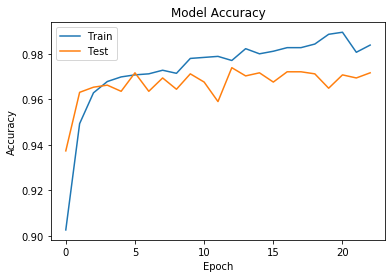

In [18]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Summarizing history for loss

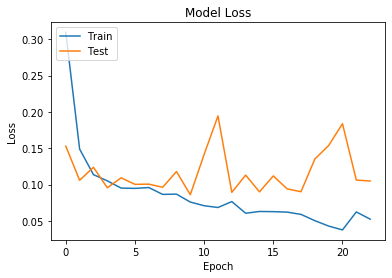

In [19]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Optional debugging of incorrectly-labeled examples

In [20]:
y_test_pred = model.predict(test_wav)
y_predicted_classes_test = y_test_pred.argmax(axis=-1)
y_actual_classes_test= test_label.argmax(axis=-1)
wrong_examples = np.nonzero(y_predicted_classes_test != y_actual_classes_test)
print(wrong_examples)

(array([   3,    6,    8,   34,   53,   68,   90,  132,  176,  179,  180,
        200,  204,  230,  292,  294,  297,  305,  318,  320,  322,  349,
        350,  376,  385,  443,  539,  561,  615,  696,  748,  768,  775,
        831,  834,  873,  942,  968, 1061, 1126, 1169, 1262, 1291, 1300,
       1359, 1365, 1475, 1508, 1561, 1606, 1632, 1717, 1750, 1806, 1826,
       2021, 2043, 2054, 2090, 2104, 2125, 2154, 2216]),)


### Optional debugging of an individual incorrectly-labeled example

In [23]:
i = 3
sample = np.reshape(test_wav[i], sampling_rate_per_two_seconds, )
sample_rate = 22050
print(y_actual_classes_test[i], y_predicted_classes_test[i])
ipd.Audio(sample, rate=sample_rate)

1 0
